# Electric Vehicle Charging Demand
---
This notebook runs an LCOE-optimized wind/solar/storage plant in Boulder, CO based on a load following schedule representing an hourly EV load demand. The EV demand was generated using EVI-Pro (Lite).

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ev.optimization.run_cases import load_case_results

/Users/cirmas/workspace/HOPP/ev/notebooks/log/hybrid_systems_2024-01-09T16.00.00.164619.log


/opt/anaconda3/envs/hopp/lib/python3.8/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [2]:
sns.set_theme()

### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [3]:
ev_load = pd.read_csv("../data/boulder_demand_evi.csv", header=None)

In [4]:
periods = 24*7
dates = pd.date_range(start="2022-01-01", periods=periods, freq="H")

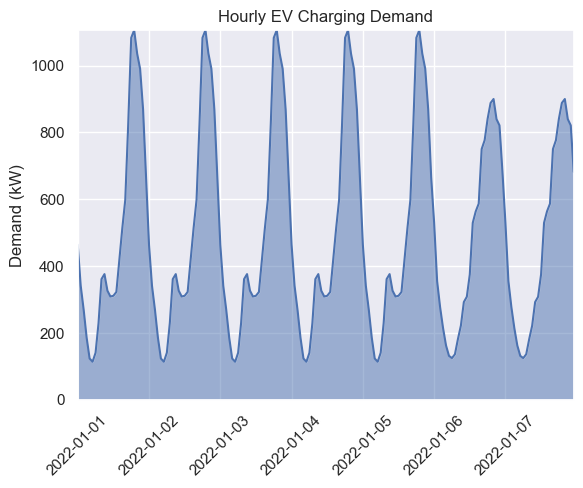

In [5]:
fig, ax = plt.subplots()
periods = 24*7
load = ev_load.iloc[:periods, 0]

ax.plot(dates, load)
ax.fill_between(dates, 0, load, alpha=0.5)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)

ax.set_title("Hourly EV Charging Demand")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.set_ymargin(0)

In [6]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=ev_load.iloc[:, 0].values / 1000, # MW
        solar=True,
        wind=True,
        wave=False
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [7]:
cases = load_case_results()

case = cases[4]

case

{'case': {'threshold_kw': 500, 'peak_req': 0.95, 'battery_hrs': 8},
 'technologies': {'pv': {'system_capacity_kw': 1025.3111083018944},
  'wind': {'turbine_rating_kw': 1092.5310851529418},
  'battery': {'system_capacity_kw': 500,
   'system_capacity_kwh': 4000.027474067858}},
 'lcoe_real': 0.09121941000671577}

In [8]:
hopp_config = load_yaml("../inputs/ev-load-following-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site

hopp_config["technologies"].update(case["technologies"])
hopp_config["technologies"]["wind"]["num_turbines"] = 1

hopp_config

{'technologies': {'pv': {'system_capacity_kw': 1025.3111083018944},
  'wind': {'turbine_rating_kw': 1092.5310851529418, 'num_turbines': 1},
  'battery': {'system_capacity_kw': 500,
   'system_capacity_kwh': 4000.027474067858},
  'grid': {'interconnect_kw': 10000, 'ppa_price': 0.05}},
 'config': {'dispatch_options': {'battery_dispatch': 'peak_shaving_heuristic',
   'load_threshold_kw': 500}},
 'site': SiteInfo(data={'lat': 35.2018863, 'lon': -101.945027, 'elev': 1099, 'year': 2012, 'tz': -6, 'site_boundaries': {'verts': [[3.0599999999976717, 288.87000000011176], [0.0, 1084.0300000002608], [1784.0499999999884, 1084.2400000002235], [1794.0900000000256, 999.6399999996647], [1494.3400000000256, 950.9699999997392], [712.640000000014, 262.79999999981374], [1216.9800000000396, 272.3600000003353], [1217.7600000000093, 151.62000000011176], [708.140000000014, 0.0]], 'verts_simple': [[3.0599999999976717, 288.87000000011176], [0.0, 1084.0300000002608], [1784.0499999999884, 1084.2400000002235], [179

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [9]:
hi = HoppInterface(hopp_config)

### Run the Simulation

In [10]:
hi.simulate()

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [11]:
hybrid_plant = hi.system

# print("Output after losses over gross output:",
      # hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

Annual Energies:
{"pv": 2138699.2220160845, "wind": 3577934.9963159733, "battery": -6112.0145516753155, "hybrid": 3060400.724178624}
Net Present Values:
{"pv": 96381.9330142074, "wind": 334510.13191969646, "battery": -906215.7286508188, "hybrid": -1756566.4384054304}


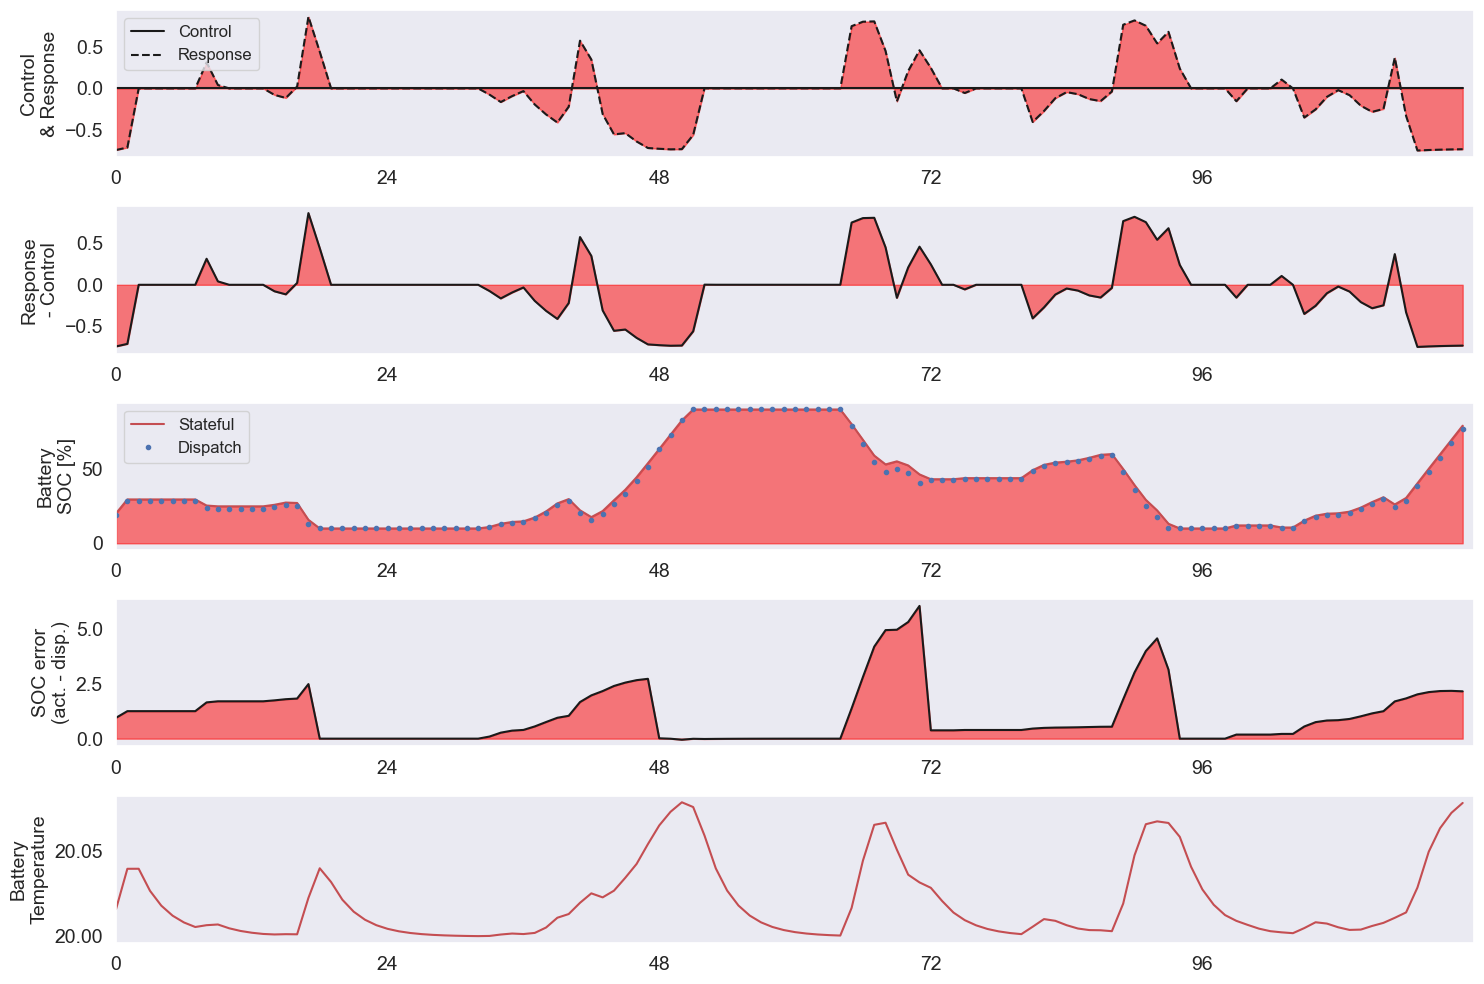

In [12]:
plot_battery_output(hybrid_plant)

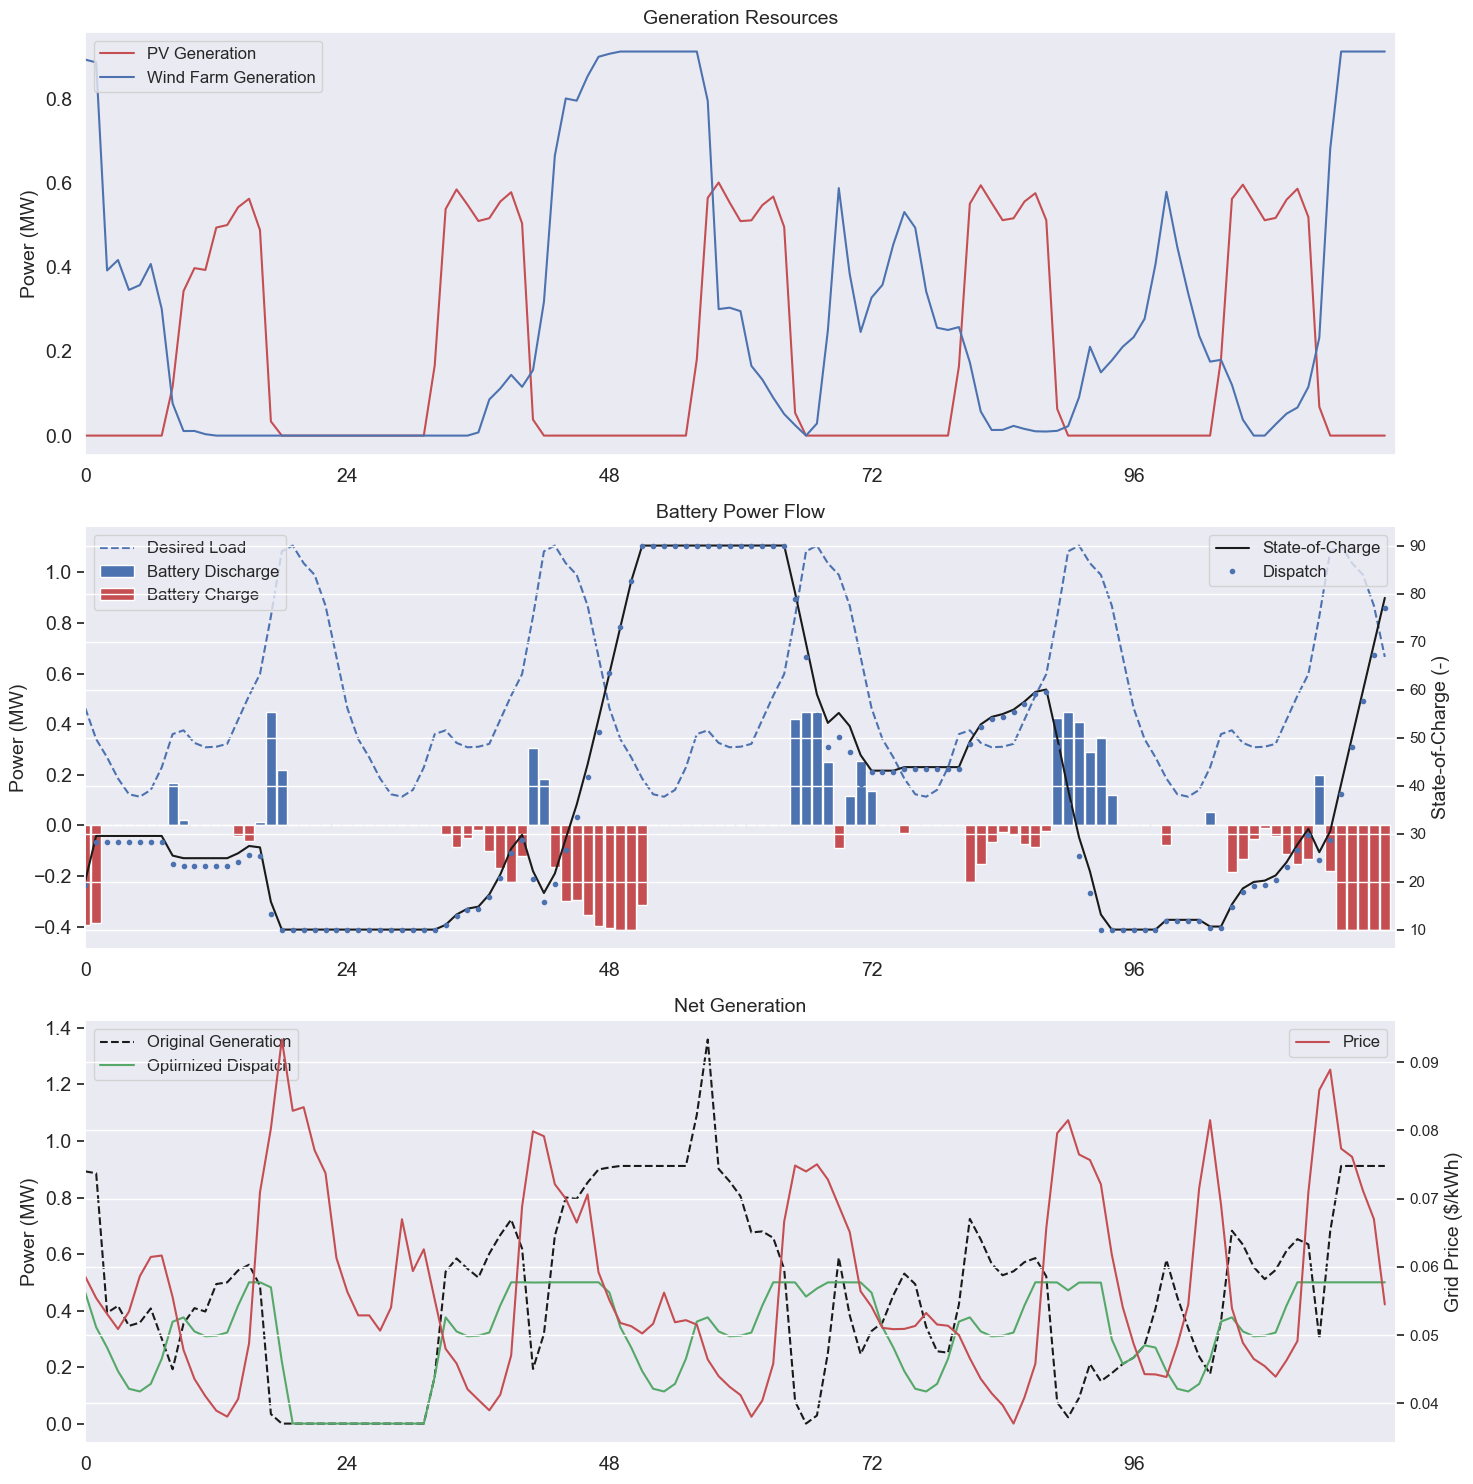

In [13]:
plot_generation_profile(hybrid_plant)

In [14]:
hybrid_plant.grid.missed_load_percentage

0.045729389196417544

In [15]:
np.mean(hybrid_plant.grid.missed_peak_load)

24.991102893820702

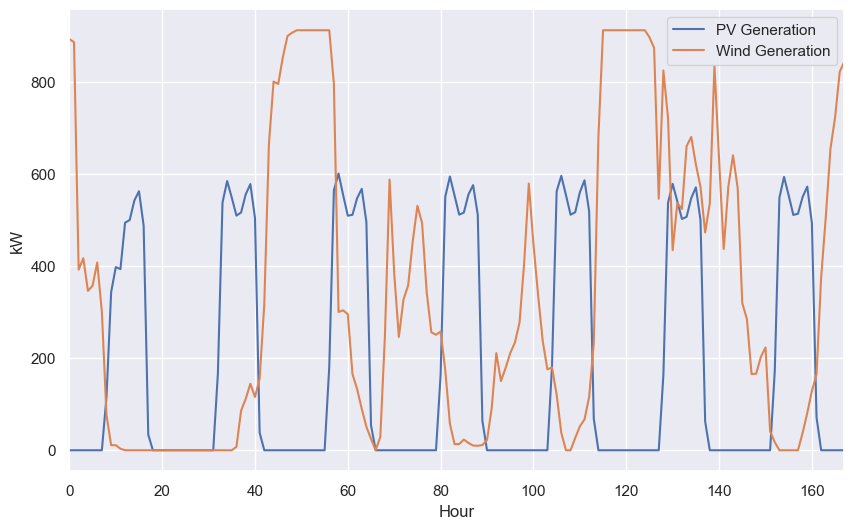

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(np.arange(24*7), hybrid_plant.grid.missed_load[:24*7], label="Missed Load")
ax.plot(np.arange(24*7), hybrid_plant.pv.generation_profile[:24*7], label="PV Generation")
ax.plot(np.arange(24*7), hybrid_plant.wind.generation_profile[:24*7], label="Wind Generation")

ax.set_xmargin(0)
ax.set_xlabel("Hour")
ax.set_ylabel("kW")
ax.legend()

In [17]:
hybrid_plant.lcoe_real["hybrid"]/100

0.09121941000671577

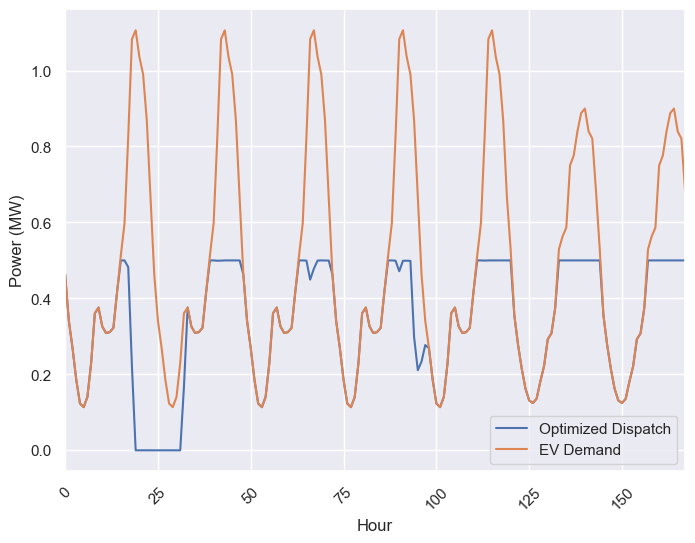

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(8760)
y = np.array(hybrid_plant.generation_profile["hybrid"]) / 1000

ax.plot(x[:periods], y[:periods], label="Optimized Dispatch")
ax.plot(x[:periods], ev_load[:periods] / 1000, label="EV Demand")

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
        
ax.set_xlabel("Hour")
ax.set_ylabel("Power (MW)")
ax.set_xmargin(0)

ax.legend()

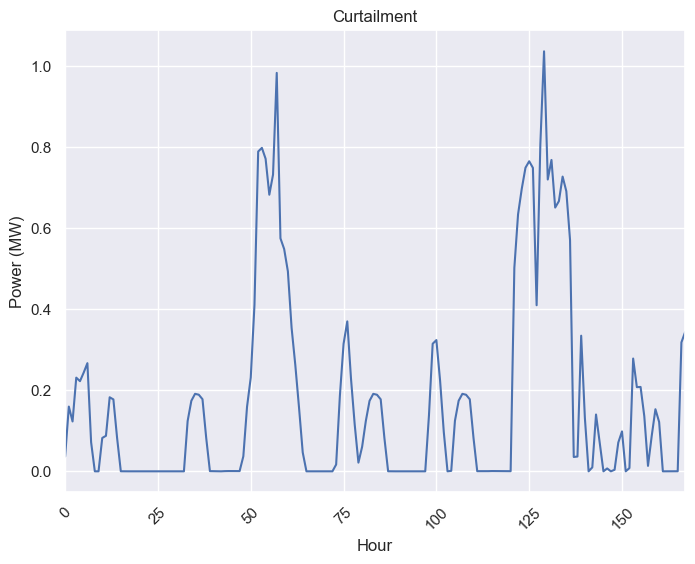

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(8760)
y = np.array(hybrid_plant.grid.schedule_curtailed) / 1000

ax.plot(x[:periods], y[:periods])

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)

ax.set_title("Curtailment")
ax.set_xlabel("Hour")
ax.set_ylabel("Power (MW)")
ax.set_xmargin(0)